# Stochastic Gradient Hamiltonian Dynamics

In [1]:
# importing libraries 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.datasets import make_classification
from sgld import *
from sghd import *
from tqdm import tqdm
import copy

from sklearn.datasets import make_classification, make_circles, make_blobs
from sklearn.preprocessing import PolynomialFeatures

### 1. Explanation of the method

By leveraging the power of SGLD in optimising the posterior over mini-batch of training samples at each iteration, we hope that, by using the principle of the Hamiltonian dynamics, we will untangle the correlation between the posterior samples by adding an additional variable $p$ (momentum). 

We recall the expression of the Hamiltonian: 
$$ H(q,p) = -\log \pi(q) + p^TMp$$

In our case, $\pi$ corresponds to the posterior distribution we want to sample from.

We use the leapfrog integrand to approximate the Hamiltonian flow and update $p$ and $q$ at each leapfrog step using the following equations: 
$$ p_{1/2} = p + \frac{h}{2} \nabla \log \pi(q)$$ 
$$ q' = q + h Mp_{1/2}$$ 
$$ p' = p_{1/2} + \frac{h}{2} \nabla \log \pi(q')$$ 

The only difference compared to classic HMC is that the updates at each iteration are computed using only a mini-batch of the training samples.

### 2. Implementation

The required functions to implement Stochastic Gradient Hamiltonian Dynamic (SGHD) are provided in the module `sghd.py`. 

### 3. Experiment on a linearly separable classes

In this notebook, we will focus on a binary classification task using a toy 2D dataset generated using `make_classification` from `sklearn`. 

> Feel to check the notebook `sgld_sghd_real_dataset.ipynb` for performance assessment on a real dataset.

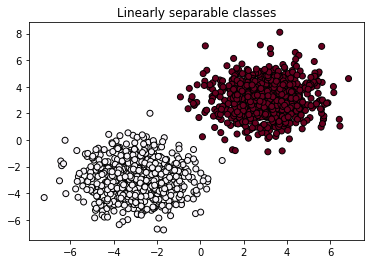

In [2]:
N = 1500 # nb of samples
X, y = make_blobs(n_samples=N, centers=[(-3,-3),(3,3)], cluster_std=1.3, n_features=2, random_state=42)
y = 2 * y - 1

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='PuRd', edgecolors='k')
plt.title("Linearly separable classes")
plt.show()

**Computing the mass matrix M**

In order to adapt the mass matrix to the shape of the posterior we want to sample from, we first compute some posterior samples using SGLD and we set `M_mass` to the covariance of these samples. 

In [9]:
# Parameters 
N, d = X.shape
a, b, gamma= 1, 40, .7 
sigma = 1.          # std. dev. of the prior on theta
batch_size = N//2
n_iter = 5000       # of iterations

# inital theta
theta_0 = np.ones(X.shape[1])    

np.random.seed(0)

# compute the mass matrix M_mass using cov. of the posterior samples from sgld 
samples, _, log_posts, alphas = sgld_logreg(X, y, theta_0, sigma=sigma, gamma=gamma, a=a, b=b, batch_size=5, n_iter=5000)

n_post_samples = 200   # nb of post. samples to extract
post_samples = samples[-n_post_samples:]
mean_post_samples = np.mean(post_samples, axis=0)
M_mass = 1/(n_post_samples-1) * (post_samples - mean_post_samples).T.dot(post_samples - mean_post_samples)

100%|██████████| 5000/5000 [00:01<00:00, 4153.37it/s]

Finished within 1.21 s.


**Plot of the posterior samples from SGLD and the traces of $\theta=(\theta_1, \theta_2)$**

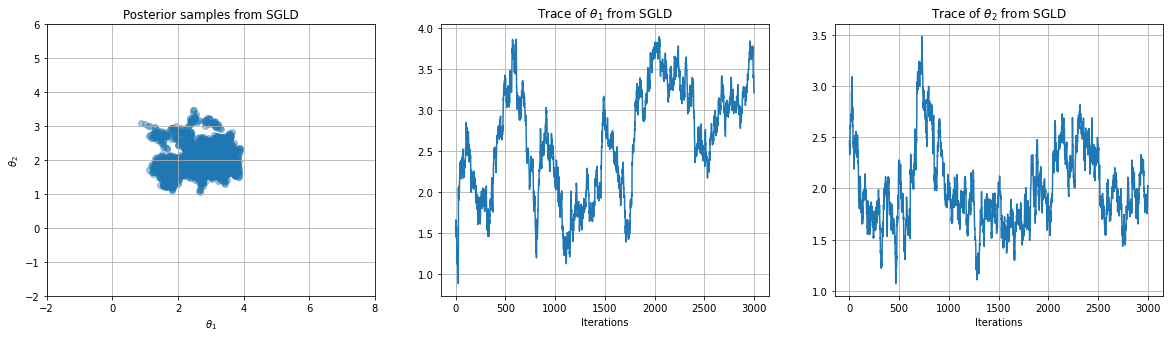

In [10]:
fig, axes = plt.subplots(1,3, figsize=(20, 5))

xlim, ylim = (-2, 8), (-2, 6)
post_samples = samples[-3000:]    # posterior samples

# plot the posterior samples 
axes[0].scatter(post_samples[:,0], post_samples[:,1], alpha=.4)
axes[0].set_title('Posterior samples from SGLD')
axes[0].set_xlim(xlim[0], xlim[1])
axes[0].set_ylim(ylim[0], ylim[1])
axes[0].set_xlabel(r'$\theta_1$')
axes[0].set_ylabel(r'$\theta_2$')
axes[0].grid()


# plot of theta1 trace
axes[1].plot(np.arange(len(post_samples)), post_samples[:,0])
axes[1].set_title(r"Trace of $\theta_1$ from SGLD")
axes[1].set_xlabel('Iterations')
axes[1].grid()

# plot of theta2 trace
axes[2].plot(np.arange(len(post_samples)), post_samples[:,1])
axes[2].set_title(r"Trace of $\theta_2$ from SGLD")
axes[2].set_xlabel('Iterations')
axes[2].grid()

plt.show()


*We notice how correlated the moves from the SGLD chain are. In case where the posterior distribution has a complex shapes with multiple modes, the SGLD chain can easily get **trapped in one mode**.*

**Visualising the decision boundary obtained by SGLD**

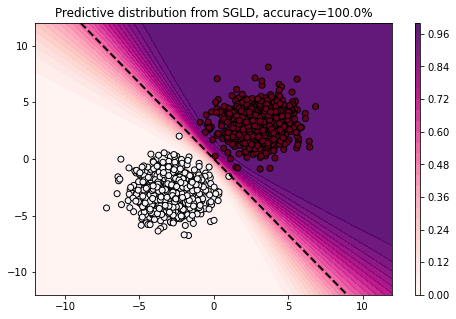

In [5]:
# estimate of the MAP
theta = post_samples[np.argmax(log_posts[-3000:])]
# estimate of the accuracy
accuracy = (np.sign(X.dot(theta)) == y).mean() * 100

# plot of the predictive dist.
x_ = np.linspace(-12, 12, 100)
y_ = np.linspace(-12, 12, 100)
xx, yy = np.meshgrid(x_, y_)
zz = np.array([[xx_, yy_] for (xx_, yy_) in zip(xx.ravel(), yy.ravel())])
ZZ = (make_predictions(zz, post_samples)).reshape(xx.shape)

# contour plot 
plt.figure(figsize=(8,5))
plt.contour(x_, y_, ZZ, colors='k', linestyles='--', linewidths=2, levels=[.5])
cont = plt.contourf(x_, y_, ZZ, 30, cmap='RdPu', vmin=ZZ.min(), vmax=ZZ.max(), alpha=.9)
plt.colorbar(cont, aspect=50)
plt.scatter(X[:,0], X[:,1], c=y, cmap='PuRd', edgecolors='k')
plt.title(f"Predictive distribution from SGLD, accuracy={accuracy}%");
plt.show()

**Training using Stochastic Gradient Hamiltonian Dynamic (SGHD)**

In [6]:
# target distribution
N, d = X.shape
a, b, gamma = .1, 40, .7
b = 40
batch_size = N // 2
n_iter = 5000  # nb of iterations
sigma = 1 
h_step = .5    # size of the leapfrog step
n_steps = 80    # nb of one Hamiltonian dynamic steps

# initialising theta
theta_0 = np.ones(d)

# posterior samples from SGHD 
samples, log_posts, accept_ratio, accept_probas = sghd_logreg(X, y, theta_0, h_step, n_steps, M_mass, sigma=sigma, gamma=gamma, a=a, b=b, batch_size=batch_size, n_iter=n_iter)
print(f'Acceptance ratio : {accept_ratio}')

100%|██████████| 5000/5000 [00:39<00:00, 126.01it/s]

Finished within 39.68 s.
Acceptance ratio : 0.7414


*Note:* For the same batch size ($N/2$), it takes more time to compute SGHD (36.74 s) than to comptue SGLD (1.27 s).

**Plot of the posterior samples from SGHD and the traces of $\theta=(\theta_1, \theta_2)$**

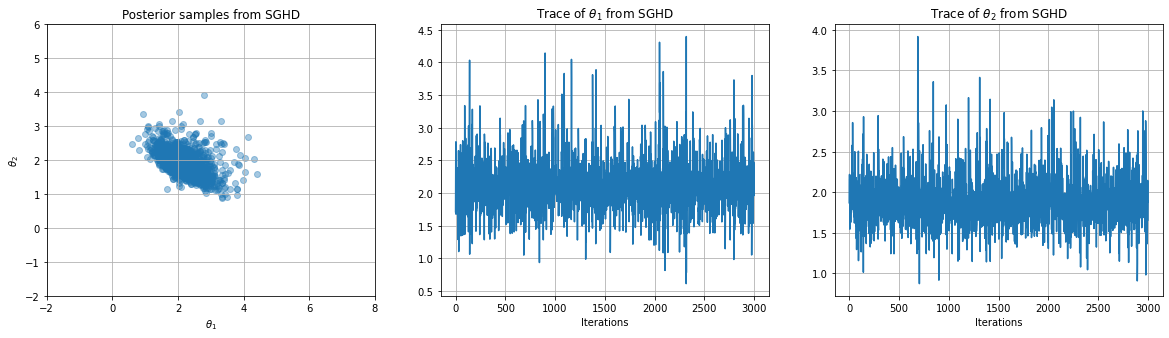

In [7]:
fig, axes = plt.subplots(1,3, figsize=(20, 5))

xlim, ylim = (-2, 8), (-2, 6)
post_samples = samples[-3000:]    # posterior samples

# plot the posterior samples 
axes[0].scatter(post_samples[:,0], post_samples[:,1], alpha=.4)
axes[0].set_title('Posterior samples from SGHD')
axes[0].set_xlim(xlim[0], xlim[1])
axes[0].set_ylim(ylim[0], ylim[1])
axes[0].set_xlabel(r'$\theta_1$')
axes[0].set_ylabel(r'$\theta_2$')
axes[0].grid()


# plot of theta1 trace
axes[1].plot(np.arange(len(post_samples)), post_samples[:,0])
axes[1].set_title(r"Trace of $\theta_1$ from SGHD")
axes[1].set_xlabel('Iterations')
axes[1].grid()

# plot of theta2 trace
axes[2].plot(np.arange(len(post_samples)), post_samples[:,1])
axes[2].set_title(r"Trace of $\theta_2$ from SGHD")
axes[2].set_xlabel('Iterations')
axes[2].grid()

plt.show()


*Clearly SGHD MC chain mixes better than the MC chain from SGLD.*

**Visualising the decision boundary obtained by SGHD**

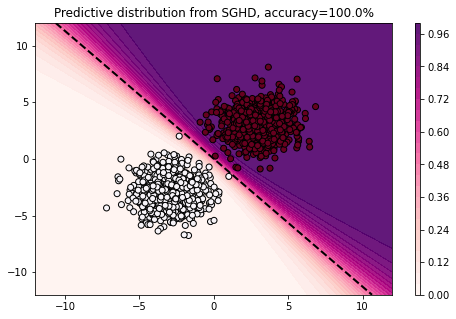

In [8]:
# estimate of the MAP
theta = post_samples[np.argmax(log_posts[-3000:])]
# estimate of the accuracy
accuracy = (np.sign(X.dot(theta)) == y).mean() * 100

# plot of the predictive dist.
x_ = np.linspace(-12, 12, 100)
y_ = np.linspace(-12, 12, 100)
xx, yy = np.meshgrid(x_, y_)
zz = np.array([[xx_, yy_] for (xx_, yy_) in zip(xx.ravel(), yy.ravel())])
ZZ = (make_predictions(zz, post_samples)).reshape(xx.shape)

# contour plot 
plt.figure(figsize=(8,5))
plt.contour(x_, y_, ZZ, colors='k', linestyles='--', linewidths=2, levels=[.5])
cont = plt.contourf(x_, y_, ZZ, 30, cmap='RdPu', vmin=ZZ.min(), vmax=ZZ.max(), alpha=.9)
plt.colorbar(cont, aspect=50)
plt.scatter(X[:,0], X[:,1], c=y, cmap='PuRd', edgecolors='k')
plt.title(f"Predictive distribution from SGHD, accuracy={accuracy}%");
plt.show()

### 4. Experiment on circular classes shape

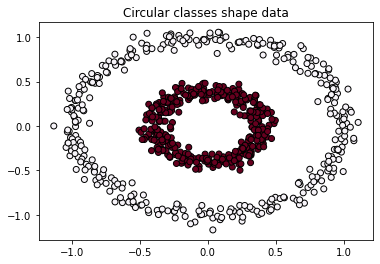

In [11]:
N = 700 # nb of samples
X, y = make_circles(n_samples=700, factor=.4, noise=.05, random_state=42)
y = 2 * y - 1

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='PuRd', edgecolors='k')
plt.title("Circular classes shape data")
plt.show()

*In this case, it is important to tranform the data to a high-dimensional feature space. For this, we can use a polynomial of degree 3 to fit the data.*

In [12]:
# transforming features 
poly_feat = PolynomialFeatures(3, include_bias=True)
X_phi = poly_feat.fit_transform(X)

print(f"Nb of new dims : {X_phi.shape[1]}")

Nb of new dims : 10


**Computing the mass matrix M**

In [13]:
# Parameters 
N, d = X_phi.shape
a, b, gamma= 1, 40, .7
sigma = 1.          # std. dev. of the prior on theta
batch_size = 50
n_iter = 5000       # of iterations

np.random.seed(0)

# inital theta
theta_0 = np.ones(X_phi.shape[1]) 

# compute the mass matrix M_mass
samples, _, log_posts, alphas = sgld_logreg(X_phi, y, theta_0, sigma=sigma, gamma=gamma, a=a, b=b, batch_size=5, n_iter=5000)

n_post_samples = 200   # nb of post. samples to extract
post_samples = samples[-n_post_samples:]
mean_post_samples = np.mean(post_samples, axis=0)
M_mass = 1/(n_post_samples-1) * (post_samples - mean_post_samples).T.dot(post_samples - mean_post_samples)


100%|██████████| 5000/5000 [00:01<00:00, 4309.60it/s]

Finished within 1.16 s.


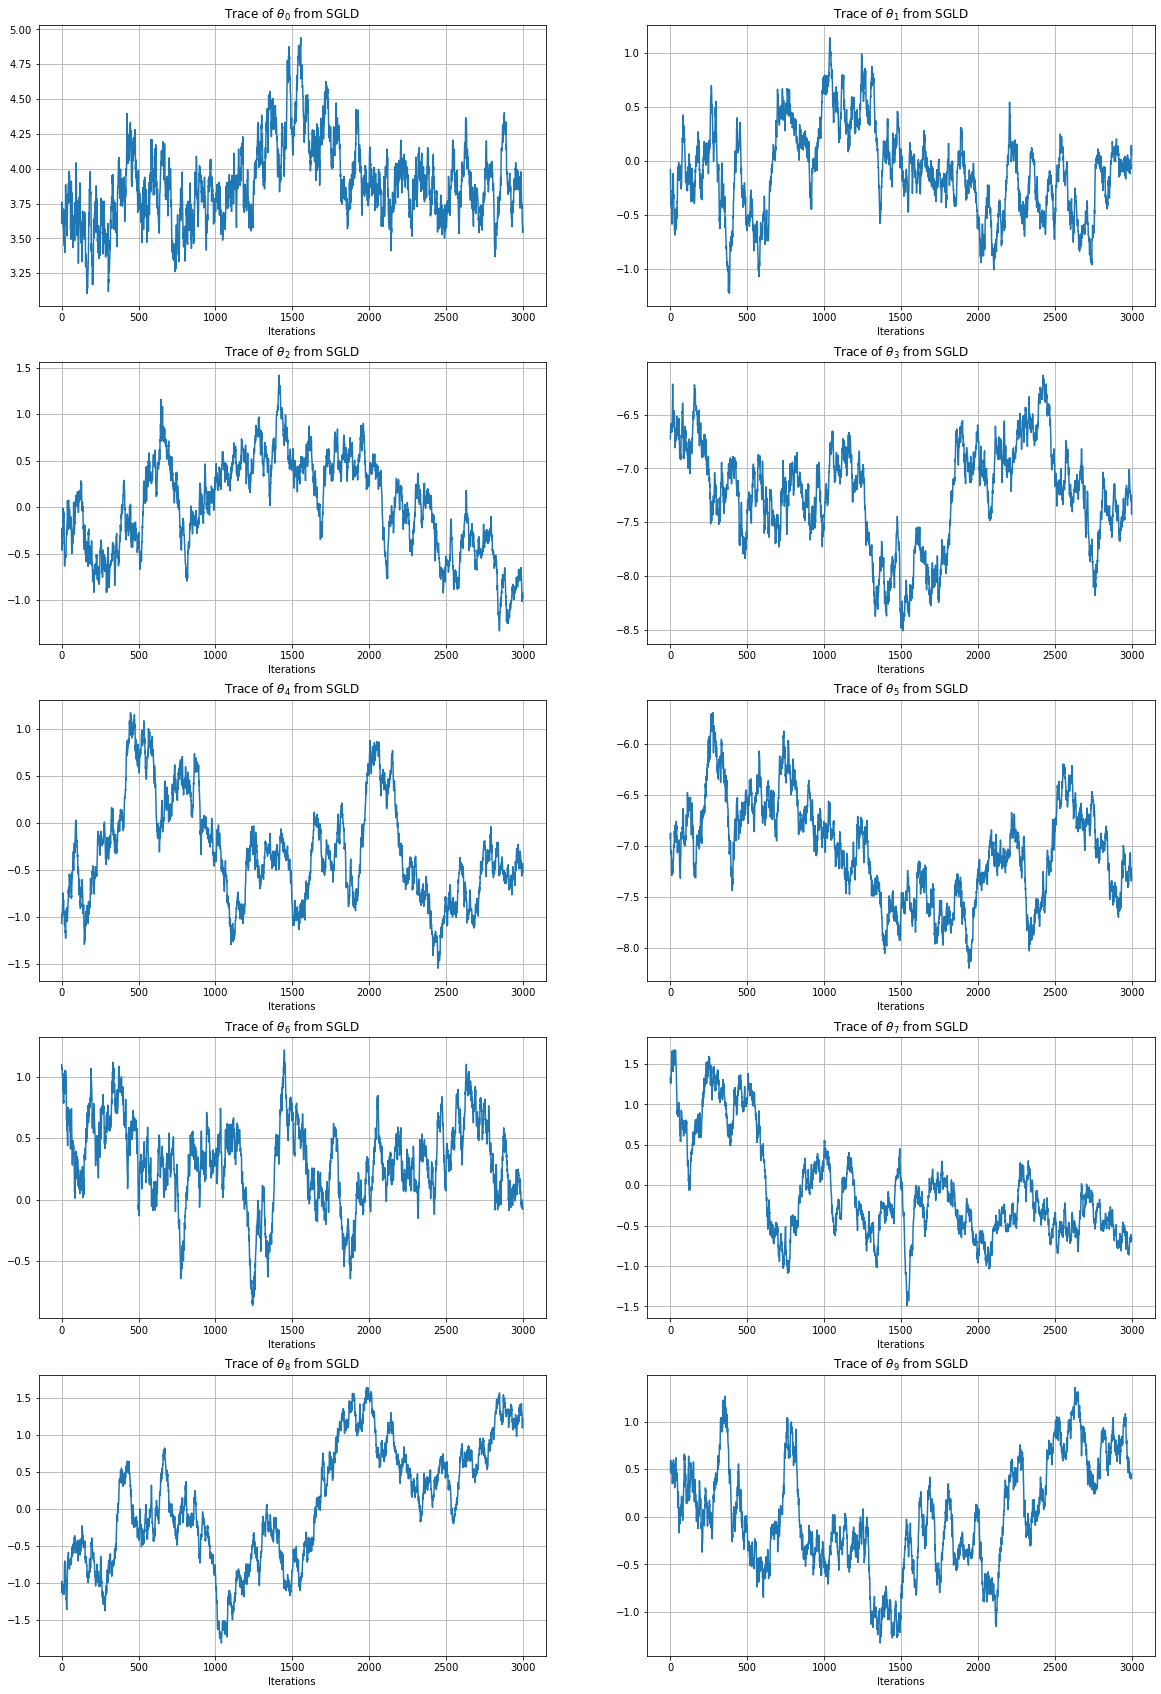

In [14]:
fig, axes = plt.subplots(5, 2, figsize=(20, 30))
axes = axes.ravel()

xlim, ylim = (-2, 8), (-2, 6)
post_samples = samples[-3000:]    # posterior samples

for i in range(10):
    axes[i].plot(np.arange(len(post_samples)), post_samples[:,i])
    axes[i].set_title("Trace of $\\theta_{0}$ from SGLD".format(i))
    axes[i].set_xlabel('Iterations')
    axes[i].grid()


*Again, we can see a global tendency on the trace plots of the SGLD chain, which is a sign of high correlation between the chain moves.*

**Decision boundary obtained using SGLD**

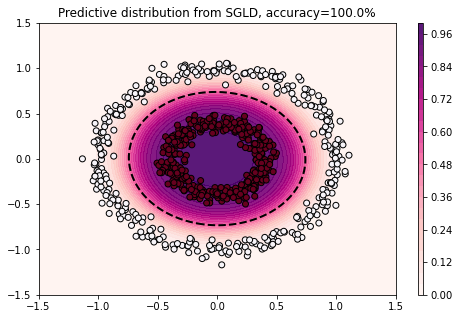

In [13]:
# estimate of the MAP
theta = post_samples[np.argmax(log_posts[-3000:])]
# estimate of the accuracy
accuracy = (np.sign(X_phi.dot(theta)) == y).mean() * 100

# plot of the predictive dist.
x_ = np.linspace(-1.5, 1.5, 100)
y_ = np.linspace(-1.5, 1.5, 100)
xx, yy = np.meshgrid(x_, y_)
zz = np.array([[xx_, yy_] for (xx_, yy_) in zip(xx.ravel(), yy.ravel())])
zz_phi = poly_feat.transform(zz)
ZZ = (make_predictions(zz_phi, post_samples)).reshape(xx.shape)
ZZ = ZZ.T


# contour plot 
plt.figure(figsize=(8,5))
plt.contour(x_, y_, ZZ, colors='k', linestyles='--', linewidths=2, levels=[.5])
cont = plt.contourf(x_, y_, ZZ, 30, cmap='RdPu', vmin=ZZ.min(), vmax=ZZ.max(), alpha=.9)
plt.colorbar(cont, aspect=50)
plt.scatter(X[:,0], X[:,1], c=y, cmap='PuRd', edgecolors='k')
plt.title(f"Predictive distribution from SGLD, accuracy={accuracy}%");
plt.show()

**Training using Stochastic Gradient Hamiltonian Dynamic (SGHD)**

In [14]:
# target distribution
N, d = X_phi.shape
a, b, gamma = .1, 40, .7
b = 40
batch_size = 50
n_iter = 5000  # nb of iterations
sigma = 1 
h_step = .5    # size of the leapfrog step
n_steps = 80    # nb of one Hamiltonian dynamic steps

# initialising theta
theta_0 = np.ones(d)

# posterior samples from SGHD 
samples, log_posts, accept_ratio, accept_probas = sghd_logreg(X_phi, y, theta_0, h_step, n_steps, M_mass, sigma=sigma, gamma=gamma, a=a, b=b, batch_size=batch_size, n_iter=n_iter)
print(f'Acceptance ratio : {accept_ratio}')

100%|██████████| 5000/5000 [00:21<00:00, 232.47it/s]

Finished within 21.51 s.
Acceptance ratio : 0.1962


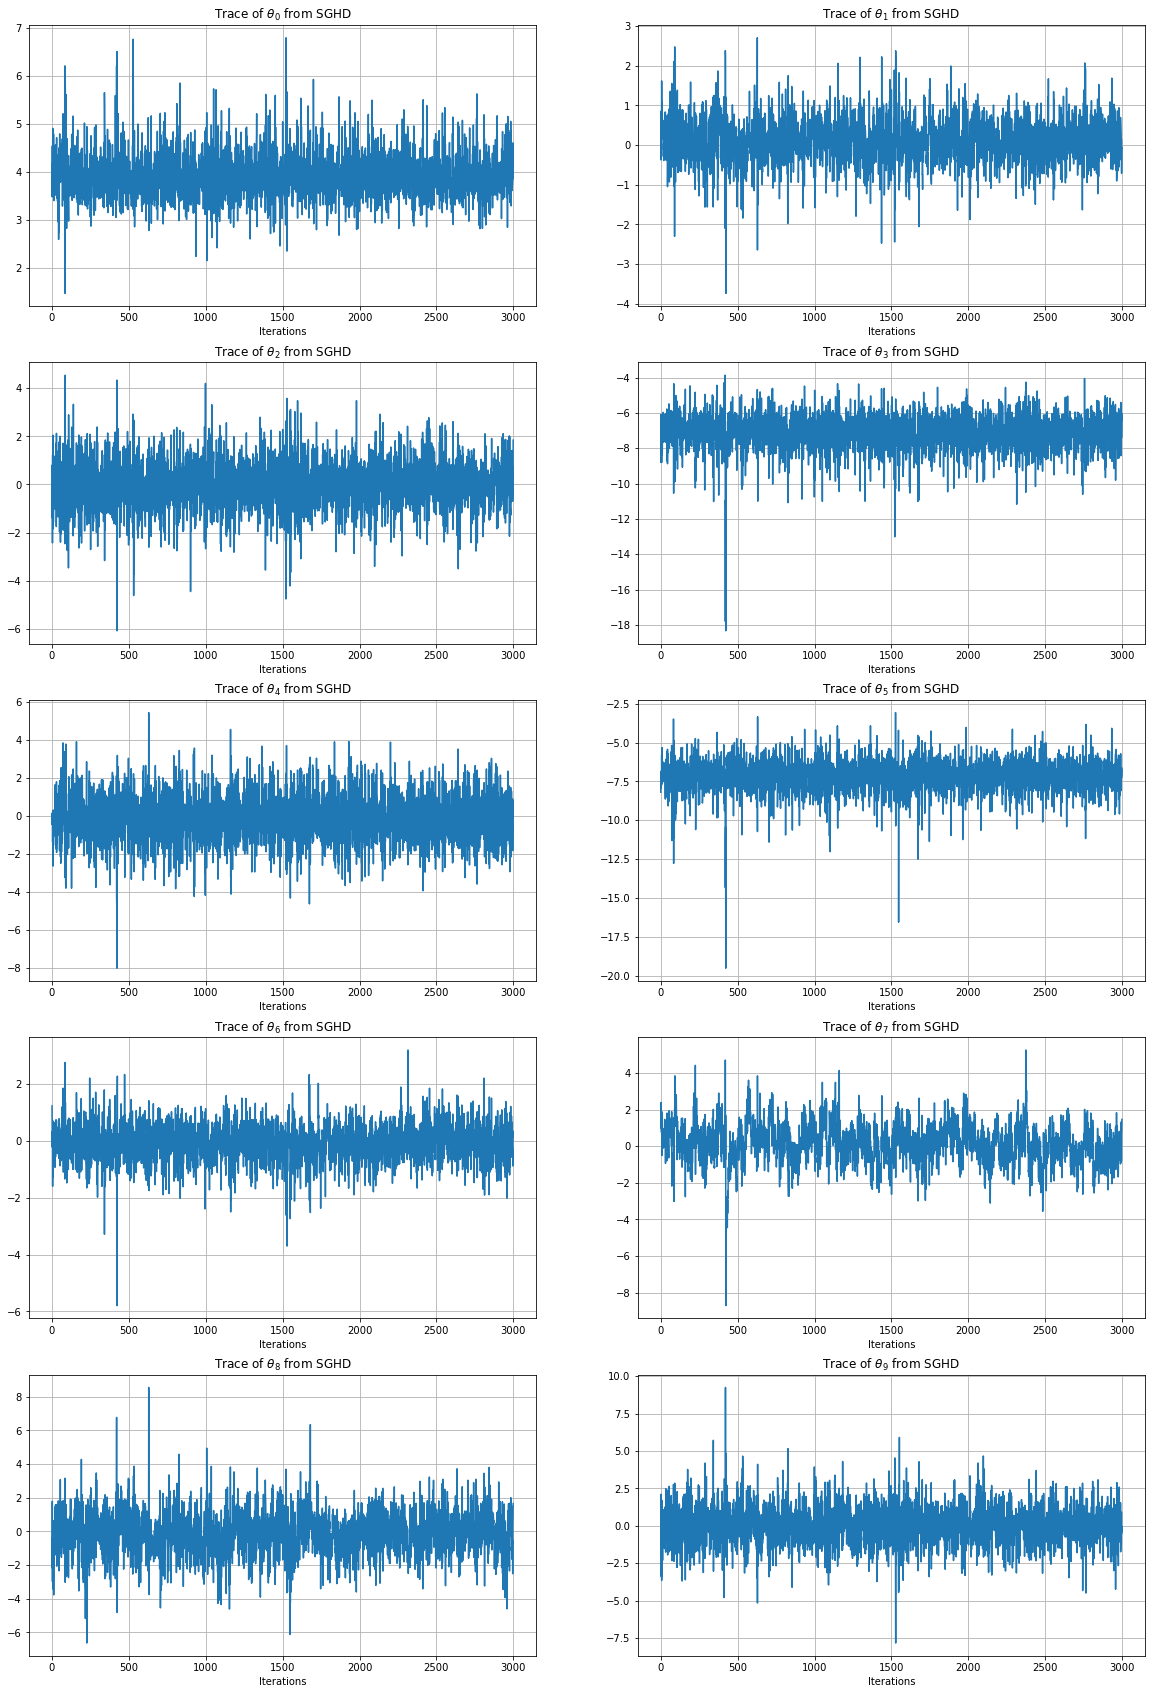

In [15]:
fig, axes = plt.subplots(5, 2, figsize=(20, 30))
axes = axes.ravel()

xlim, ylim = (-2, 8), (-2, 6)
post_samples = samples[-3000:]    # posterior samples

for i in range(10):
    axes[i].plot(np.arange(len(post_samples)), post_samples[:,i])
    axes[i].set_title("Trace of $\\theta_{0}$ from SGHD".format(i))
    axes[i].set_xlabel('Iterations')
    axes[i].grid()


*Again, SGHD mixes better than than SGLD.*

**Decision boundary obtained using SGHD**

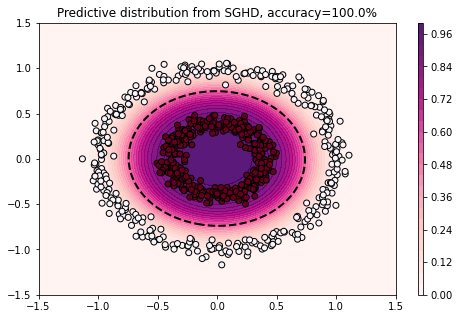

In [16]:
# estimate of the MAP
theta = post_samples[np.argmax(log_posts[-3000:])]
# estimate of the accuracy
accuracy = (np.sign(X_phi.dot(theta)) == y).mean() * 100

# plot of the predictive dist.
x_ = np.linspace(-1.5, 1.5, 100)
y_ = np.linspace(-1.5, 1.5, 100)
xx, yy = np.meshgrid(x_, y_)
zz = np.array([[xx_, yy_] for (xx_, yy_) in zip(xx.ravel(), yy.ravel())])
zz_phi = poly_feat.transform(zz)
ZZ = (make_predictions(zz_phi, post_samples)).reshape(xx.shape)
ZZ = ZZ.T


# contour plot 
plt.figure(figsize=(8,5))
plt.contour(x_, y_, ZZ, colors='k', linestyles='--', linewidths=2, levels=[.5])
cont = plt.contourf(x_, y_, ZZ, 30, cmap='RdPu', vmin=ZZ.min(), vmax=ZZ.max(), alpha=.9)
plt.colorbar(cont, aspect=50)
plt.scatter(X[:,0], X[:,1], c=y, cmap='PuRd', edgecolors='k')
plt.title(f"Predictive distribution from SGHD, accuracy={accuracy}%");
plt.show()

### 5. Conclusion

In this notebook, we adapted the strategy from the paper Bayesian Learning via Stochastic Gradient Langevin Dynamics to the Hamiltonian Markov process. In fact, SGLD proved to be more efficient for sampling from the posterior in that it only computes the gradient on a mini-batch of training samples.

However, the main disadvantage of this method is that it can easily get trapped in one posterior mode as the gradiet step sizes $\epsilon_t$ decrease. In practice, **we have notice how correlated the chain moves are when using SGLD**. 

On the ohter, we leverage the power of the Hamiltonian process which, in some way, computes several steps of SGLD, allowing the chain to explore further areas of the posterior domain. Indeed, **the trace plots obtained using SGHD are mixing well** compared to the SGLD chain.

Nevertheless, it is worth mentioning some perspectives of improvement of both algorithms: 
* In some cases, **SGHD performs poorly** compared to SGLD when the **batch size is too small**(<10).
* **SGHD is less stable when changing the initial parameter $\theta_0$** compared to SGLD.
* **The performance of SGHD mass matrix $M$** used to compute the "kinetic energy" in the Hamiltonian. In fact, for a good performance, once should care about encoding relevant posterior information into M. In our case, we have used the covariance matrix of posterior samples computed from SGLD. This is in practice a real limitation when there is no easy access to this information.
* Using both of the algorithms needs a preliminary step of **tuning the parameters $a, b, \gamma$**.


#### References:

* Max Welling and Yee Whye Teh. 2011. "[Bayesian learning via Stochastic Gradient Langevin Dynamics](https://www.stats.ox.ac.uk/~teh/research/compstats/WelTeh2011a.pdf)". In Proceedings of the 28th International Conference on International Conference on Machine Learning (ICML'11). Omnipress, Madison, WI, USA, 681–688.

* Neal, Radford. 2011. “[MCMC Using Hamiltonian Dynamics.](https://arxiv.org/pdf/1206.1901.pdf)” In Handbook of Markov Chain Monte Carlo, edited by Steve Brooks, Andrew Gelman, Galin L. Jones, and Xiao-Li Meng, 116–62. Chapman; Hall/CRC.